In [123]:
from dotenv import load_dotenv
load_dotenv()

True

In [124]:
# Vector store
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai.embeddings import OpenAIEmbeddings

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_only = [item for doc in docs for item in doc]

# Text splitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
  chunk_size=256,
  chunk_overlap=50
)

doc_splits = text_splitter.split_documents(docs_only)

vectorstore = Chroma.from_documents(
  documents=doc_splits,
  embedding=OpenAIEmbeddings(),
  collection_name="rag-chroma",
)

retriever = vectorstore.as_retriever()


In [125]:
from langchain_ollama import ChatOllama

tool_llm = ChatOllama(model="llama3.2", temperature=0)


import os
from typing import Optional
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

class ChatOpenRouter(ChatOpenAI):
  openai_api_base: str
  api_key: str
  model_name: str
  
  def __init__(
      self,
      model_name: str,
      openai_api_base: str = "https://openrouter.ai/api/v1",
      api_key: Optional[str] = None,
      **kwargs
    ):
    api_key = api_key or os.getenv("OPENROUTER_API_KEY")
    super().__init__(
      openai_api_base=openai_api_base,
      api_key=api_key,
      model_name=model_name,
      **kwargs
    )
    
# meta-llama/llama-3.1-405b-instruct:free
llm = ChatOpenRouter(model_name="meta-llama/llama-3-8b-instruct:free", temperature=0)
# tool_llm = ChatGroq(model="llama-3.2-90b-vision-preview")

In [126]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [127]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  question: str
  generation: str
  documents: List[str] = []

In [128]:
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

def retrieve(state):
  print("---Retrieve___")
  documents = retriever.invoke(state['question'])
  return {
    'documents': documents
  }
  
def generate(state):
  print("---Generate---")

  prompt = f"""
  You are an assistant for question-answering tasks.
  Use the following pieces of retrieved context to answer the question.
  If you don't know the answer, just say that you don't know. 
  Use three sentences maximum and keep the answer concise.

  Question: {state['question']}
  Context: {state['documents']}
  Answer: 
  """
  response = llm.invoke(prompt)
  return {
    'generation': response
  }
  
def grade_documents(state):
  print("---Grade Documents---")

  class GradeDcouments(BaseModel):
    binary_score: str = Field(
    description="Documents are relevant to the question, 'yes' or 'no'"
  )
  
  structured_llm_grader = tool_llm.with_structured_output(GradeDcouments)

  sys_msg = """
    You are a grader assessing relevance of a retrieved document to a user questions.
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
    Give a binary score 'yes' or 'no' score to indicate wether the document is relevant to the question.
    """
  filtered_docs = []
  for doc in state['documents']:
    retrieval_grade = structured_llm_grader.invoke([
      SystemMessage(content=sys_msg), 
      HumanMessage(content=f"user question: {state['question']}\n\n Retrieved document:\n{doc}")
    ])
    
    if retrieval_grade == "yes":
      print("---Grade: Passed---")
      filtered_docs.append(doc)
    else:
      print("---Grade: Failed---")
      continue
  
  return {
    'documents': filtered_docs
  }
  
def transform_query(state):
  print("---Transform Query---")
  
  sys_msg = """
  You are a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
  Look at the input and try to reason about the u nderlying semantic intent / meaning.
  """
  
  rewritten_question = llm.invoke([
    SystemMessage(content=sys_msg),
    HumanMessage(content=f"Here is the initial question: \n\n {state['question']} \n Formulate an imporved question.")
  ])
  
  return {
    "question": rewritten_question.content
  }

from langchain_core.documents import Document

def web_search(state):
  print("---Web Search---")
  docs = web_search_tool.invoke(state['question'])
  web_results = "\n".join([d['content'] for d in docs])
  web_results = Document(page_content=web_results)
  return {
    'documents': web_results
  }

In [ ]:
from typing import Literal

def route_question(state) -> Literal['web_search', 'retrieve']:
  print("---Route Question---")
  
  class RouteQuery(BaseModel):
    datasource: Literal["retrieve", "web_search"] = Field(
      description="Given a user question shoose to route it to web search or a retrieve"
    )
    
  structured_llm_router = tool_llm.with_structured_output(RouteQuery)
  sys_msg = """
  You are an expert at routing a user question to a retrieve or web search.
  The retrieve contains documents related to agents, prompt engineering, and adversarial attacks.
  Use the retrieve for questions on these topics. Otherwise, use web-search.
  """

  source = structured_llm_router.invoke([
    SystemMessage(content=sys_msg),
    HumanMessage(content=f"{state['question']}")
  ])
  
  if source.datasource == 'web_search':
    print("---Route: Web Search---")
    return 'web_search'
  elif source.datasource == 'retrieve':
    print("---Route: retrieve---")
    return 'retrieve'
  print("---Router error Nothing??----")

def decide_to_generate(state) -> Literal['generate', 'transform_query']:
  print("---Assess Graded Documents---")
  if not state['documents']:
    print("---Decision: No relevant documents found, transform query---")
    return "transform_query"
  else:
    print("---Decision: generate---")
    return "generate"
  
  
def grade_generation_v_documents_and_questions(state):
  print("---Check hallucinations---")
  
  class GradeHallucinations(BaseModel):
    binary_score: str = Field(
      description="Answer is grounded in the facts, 'yes' or 'no'"
    )
  
  structured_llm_grader = tool_llm.with_structured_output(GradeHallucinations)
  
  generation_sys_msg = """
  You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. 
  Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts
  """
  
  score = structured_llm_grader.invoke([
    SystemMessage(content=generation_sys_msg),
    HumanMessage(content=f"Set of facts: \n\n {state['documents']} \n\n LLM generation: {state['generation']}"),
  ])
  grade = score.binary_score
  
  class GradeAnswer(BaseModel):
   binary_score: str = Field(
     description="Answer addresses the question, 'yes' or 'no'"
   )
  answer_sys_msg = """
  You are a grader assessing whether an answer addresses / resolves a question.
  Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question.
  """
  
  structured_answer_grader = tool_llm.with_structured_output(GradeAnswer)
  
  if grade == "yes":
    print("---Generation is grounded in documents---")
    answer_score = structured_answer_grader.invoke([
      SystemMessage(content=answer_sys_msg),
      HumanMessage(content=f"Question: {state['question']} \n\n LLM generation: {state['generation']}")
    ])
    answer_grade = answer_score.binary_score
    if answer_grade == "yes":
      print("---Answer addresses the question---")
      return 'useful'
    else:
      print("---Answer does not address the question---")
      return 'not_useful'
  else:
    print("---Generation is not grounded in documents---")
    return "not supported"
  

In [130]:
from langgraph.graph import END, START, StateGraph


builder = StateGraph(GraphState)

builder.add_node('web_search', web_search)
builder.add_node('retrieve', retrieve)
builder.add_node('grade_documents', grade_documents)
builder.add_node('generate', generate)
builder.add_node('transform_query', transform_query)

builder.add_conditional_edges(START, route_question)
builder.add_edge('web_search', 'generate')
builder.add_edge('retrieve', 'grade_documents')
builder.add_conditional_edges('grade_documents', decide_to_generate)
builder.add_edge('transform_query', 'retrieve')
builder.add_conditional_edges('generate', grade_generation_v_documents_and_questions, {
  "not supported": "generate",
  "useful": END,
  "not useful": "transform_query"
})

agent = builder.compile()





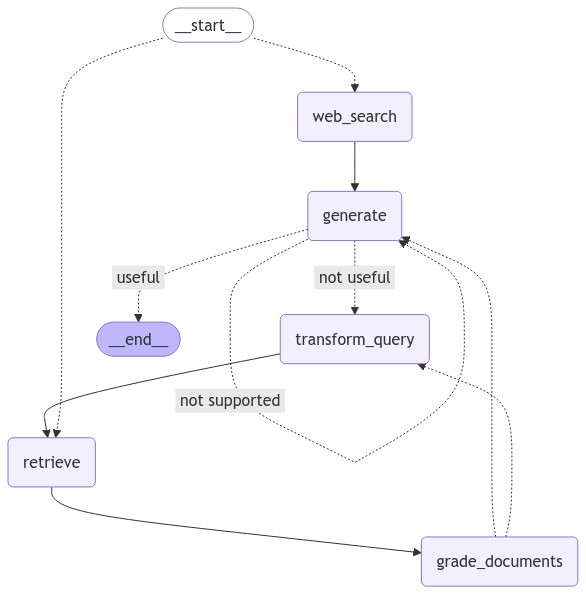

In [131]:
from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))

In [132]:
inputs = {
  "question": "What are the types of agent memory?"
}

for output in agent.stream(inputs):
  for node, value in output.items():
    print(f"{node = }")

# final answer
print(value['generation'])

---Route Question---
---Route: retrieve---
---Retrieve___
node = 'retrieve'
---Grade Documents---
---Grade: Failed---
---Grade: Failed---
---Grade: Failed---
---Grade: Failed---
---Assess Graded Documents---
---Decision: No relevant documents found, transform query---
node = 'grade_documents'
---Transform Query---
node = 'transform_query'
---Retrieve___
node = 'retrieve'
---Grade Documents---
---Grade: Failed---
---Grade: Failed---
---Grade: Failed---
---Grade: Failed---
---Assess Graded Documents---
---Decision: No relevant documents found, transform query---
node = 'grade_documents'
---Transform Query---
node = 'transform_query'
---Retrieve___
node = 'retrieve'
---Grade Documents---
---Grade: Failed---
---Grade: Failed---
---Grade: Failed---
---Grade: Failed---
---Assess Graded Documents---
---Decision: No relevant documents found, transform query---
node = 'grade_documents'
---Transform Query---
node = 'transform_query'
---Retrieve___
node = 'retrieve'
---Grade Documents---
---Grade

KeyboardInterrupt: 